# Exemplar Demonstration of TFNOS performance vs NBS T-statistic threshold

In [ ]:
import os
import sys
sys.path.append(os.path.abspath(".."))

import time
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tfnbs import compute_p_val, fisher_r_to_z, generate_fc_matrices, compute_t_stat_diff, compu2te_t_stat_tfnos_diffs

%load_ext autoreload
%autoreload 2

### Loading FC Matrices for comparison

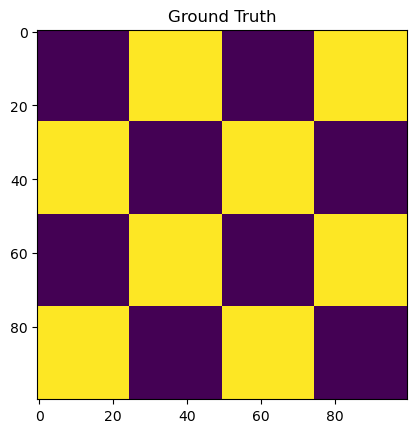

In [2]:
path_to_data = '../datasets/02_BLOCK_VAR_HRF_SNR05_CORRDIFF/'
ground_true = loadmat(path_to_data+'ground_truth_symm_matrix.mat')['ground_truth']

plt.imshow(ground_true)
plt.title('Ground Truth')
plt.show()

In [30]:
def plot_2_matrix(mat1, mat2, title1, title2, cmap = 'viridis'):
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 
    
    axes = axes.flatten()
    axes[0].imshow(mat1, cmap=cmap)  
    axes[0].set_title(title1); axes[0].axis('off')  
    
    im2 = axes[1].imshow(mat2, cmap=cmap)
    axes[1].set_title(title2); axes[1].axis('off')
    
    fig.tight_layout()
    plt.show()



def plot_4_matrix(mat1, mat2, title1, title2, 
                  mat3, mat4, title3, title4, 
                  cmap = 'viridis'):
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 14)) 
    
    axes = axes.flatten()
    axes[0].imshow(mat1, cmap=cmap)  
    axes[0].set_title(title1); axes[0].axis('off')  
    
    im2 = axes[1].imshow(mat2, cmap=cmap)
    axes[1].set_title(title2); axes[1].axis('off')

    im3 = axes[2].imshow(mat3, cmap=cmap)
    axes[2].set_title(title3); axes[2].axis('off')

    im4 = axes[3].imshow(mat4, cmap=cmap)
    axes[3].set_title(title4); axes[3].axis('off')
    
    fig.tight_layout()
    plt.show()


#### Computed Statistics using False discovery rate and Family wise error rates

In [4]:
# Previously computed Statistics using False Discovery Rate 
FdrAB = loadmat(path_to_data+'Task_A_vs_B_FDR05.mat')['thresholded']
FdrBA = loadmat(path_to_data+'Task_B_vs_A_FDR05.mat')['thresholded']

# Previously computed statistics using Family-wise error rate 
NBS_AB = loadmat(path_to_data+'Task_A_vs_B_NBS_FWEextent_05.mat')['thresholded']
NBS_BA = loadmat(path_to_data+'Task_B_vs_A_NBS_FWEextent_05.mat')['thresholded']

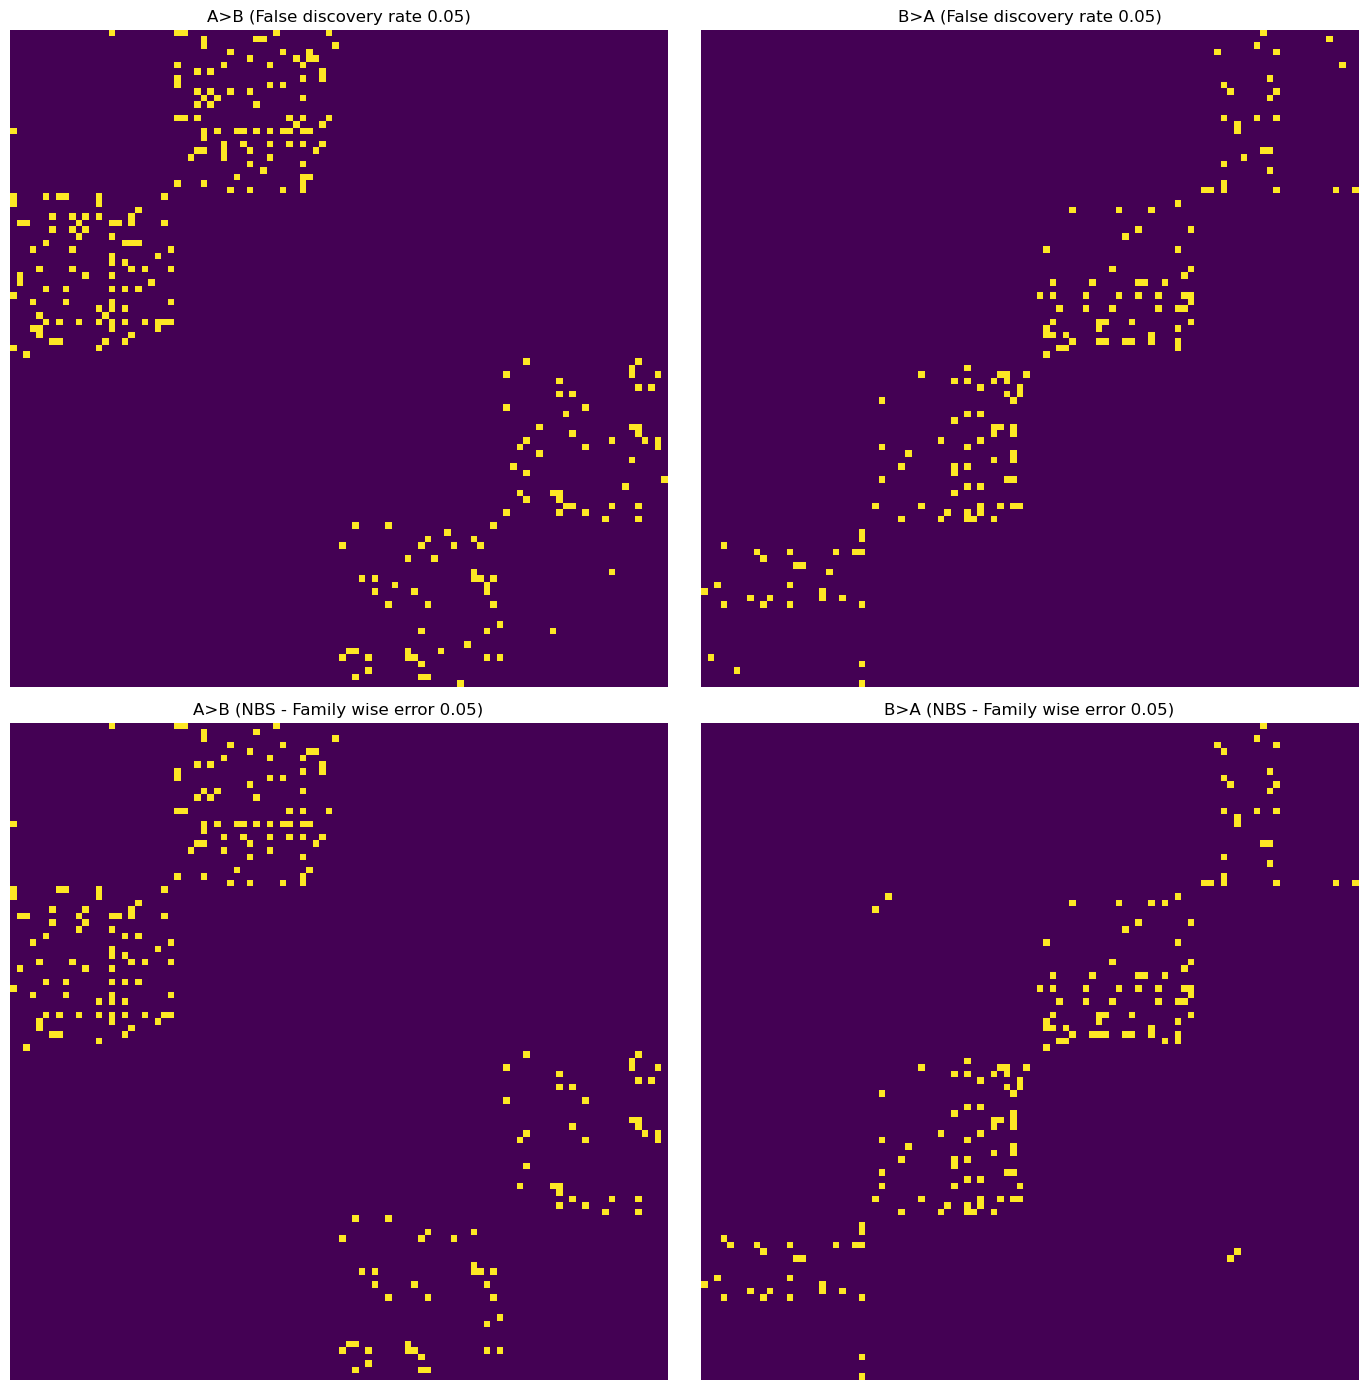

In [31]:
plot_4_matrix(FdrAB, FdrBA, "A>B (False discovery rate 0.05)", "B>A (False discovery rate 0.05)",
              NBS_AB, NBS_BA, "A>B (NBS - Family wise error 0.05)", "B>A (NBS - Family wise error 0.05)",
              cmap = 'viridis')

## Network Based Statistics using bctpy approach 

We contrast the results of bctpy, a replication of brain connectivity toolbox's ython version at (https://github.com/aestrivex/bctpy/tree/master)

In [6]:
from tfnbs import nbs_bct

In [7]:
def prepare_group(arr, swap_axis=True):
    arr = np.nan_to_num(arr, posinf=0, neginf=0)
    arr = fisher_r_to_z(arr)
    if swap_axis:
        arr  = arr.swapaxes(0, 2)
    return arr

In [8]:
taskA = prepare_group(loadmat(path_to_data+'Task_A.mat')['corrdiff_TaskA'], swap_axis=True)
taskB = prepare_group(loadmat(path_to_data+'Task_B.mat')['corrdiff_TaskB'], swap_axis=True)

#### Computing NBS approach using thresholds t = [2.1, 2.75]


In [22]:
%%time
thres_1 = 2.1
pvals_BA_t1, adj_BA_t1, _ = nbs_bct(taskA, taskB, thres_1, n_permutations=100, paired=True,use_mp = True)
pvals_AB_t1, adj_AB_t1, _ = nbs_bct(taskA, taskB, thres_1, n_permutations=100, paired=True,use_mp = True)

Wall time: 8.42 s


In [23]:
%%time
thres_2 = 2.75
pvals_BA_t2, adj_BA_t2, _ = nbs_bct(taskA, taskB, thres_2, n_permutations=100, paired=True,use_mp = True)
pvals_AB_t2, adj_AB_t2, _ = nbs_bct(taskA, taskB, thres_2, n_permutations=100, paired=True,use_mp = True)

Wall time: 8.56 s


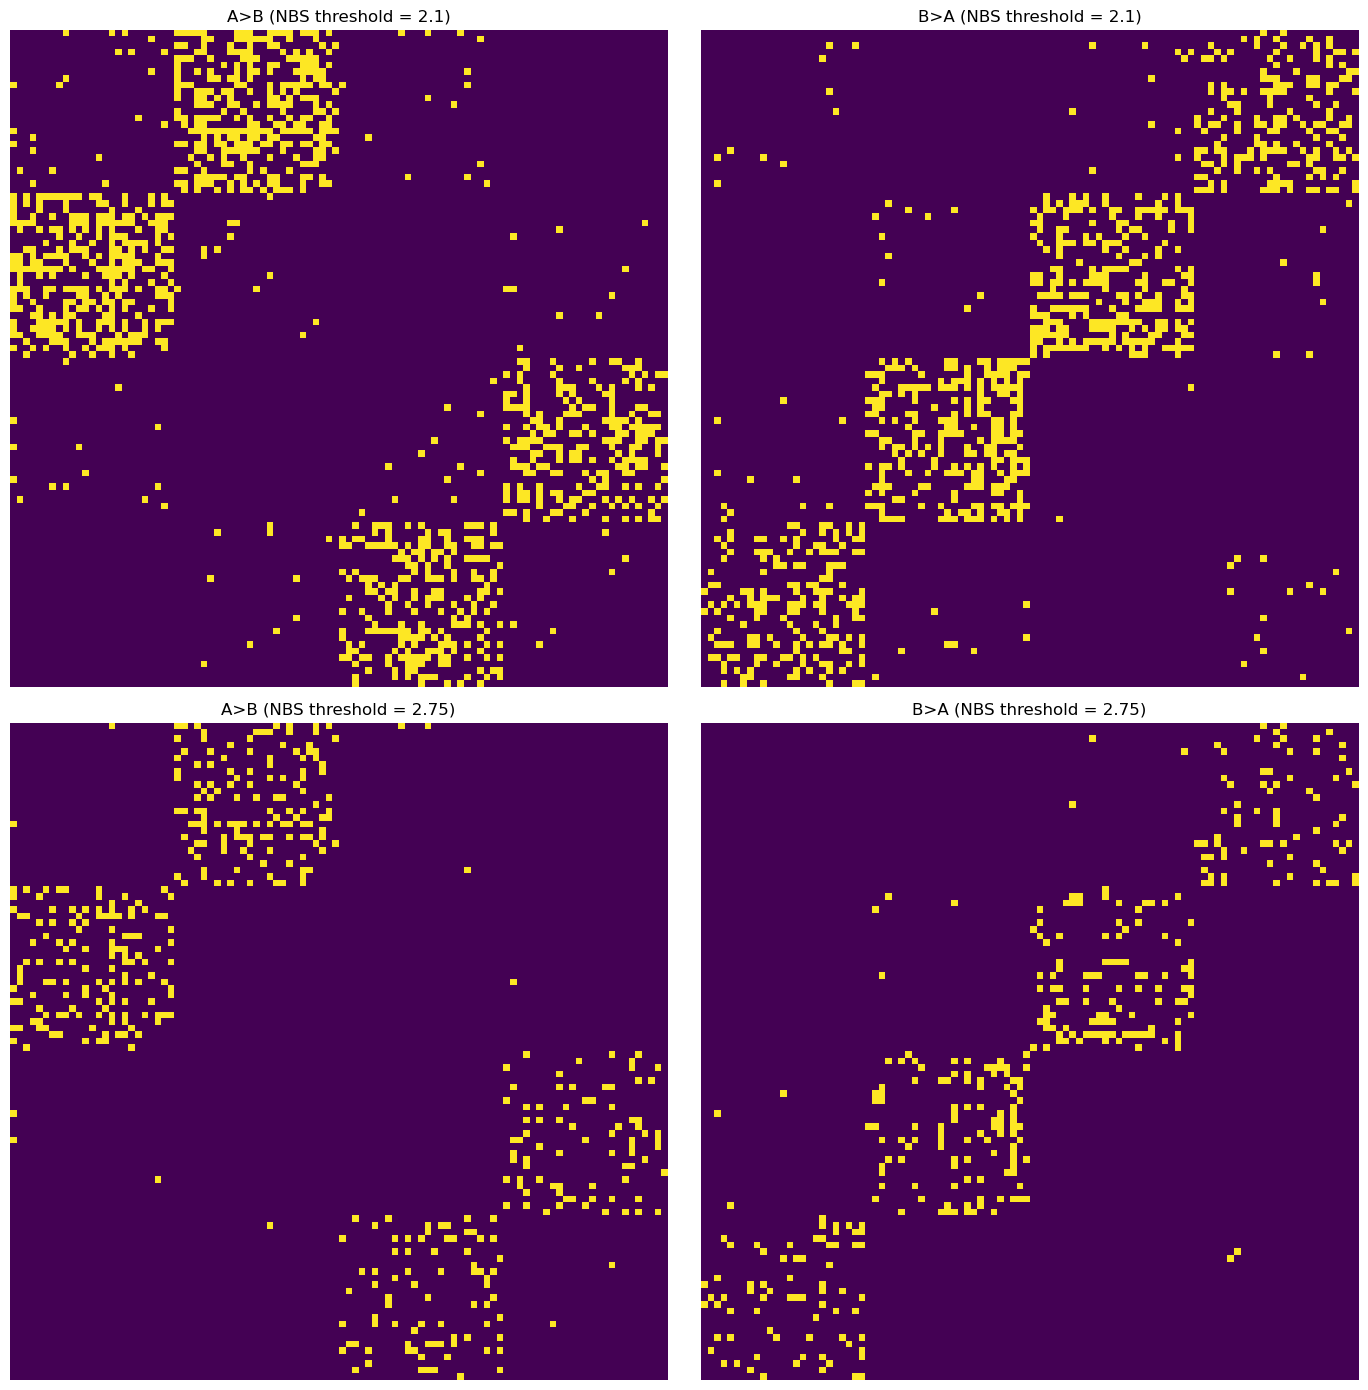

In [33]:
plot_4_matrix(adj_BA_t1['g1>g2'], adj_BA_t1['g2>g1'], "A>B (NBS threshold = 2.1)", "B>A (NBS threshold = 2.1)",
              adj_BA_t2['g1>g2'], adj_BA_t2['g2>g1'], "A>B (NBS threshold = 2.75)", "B>A (NBS threshold = 2.75)",
              cmap = 'viridis')

## TFNOS comparison against bctpy approach

We introduce our python implementation of Threshold free approach based on  [Statistical inference in brain graphs using threshold-free network-based statistics](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.24007)

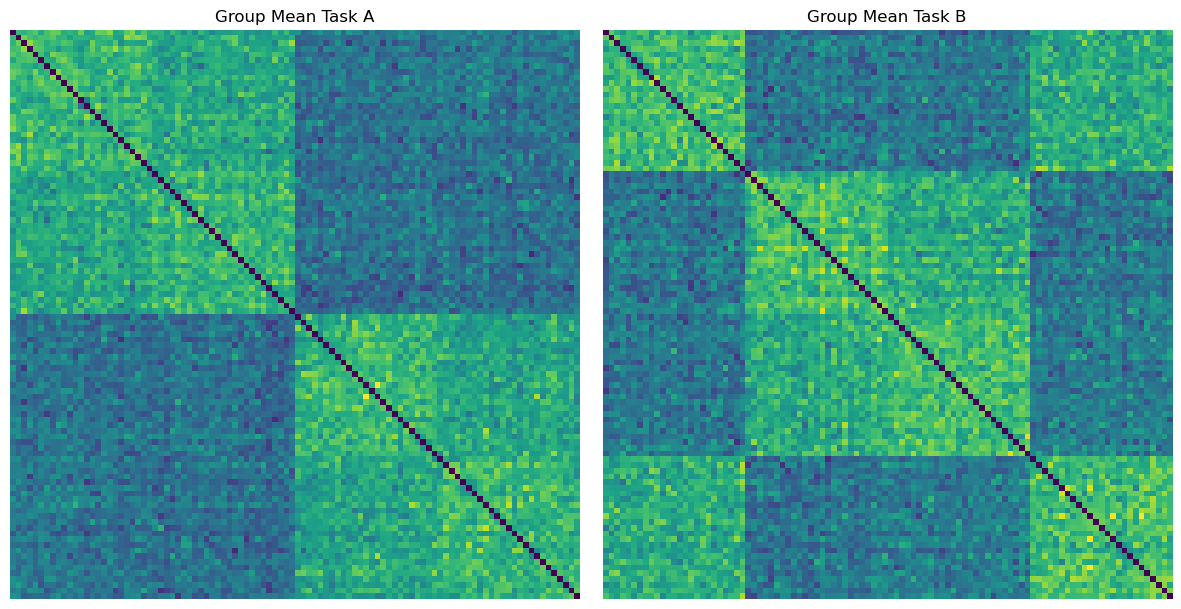

In [35]:
taskA = prepare_group(loadmat(path_to_data+'Task_A.mat')['corrdiff_TaskA'], swap_axis=True)
taskB = prepare_group(loadmat(path_to_data+'Task_B.mat')['corrdiff_TaskB'], swap_axis=True)
title1, title2 = "Group Mean Task A", "Group Mean Task B"
plot_2_matrix(taskA.mean(axis=0), taskB.mean(axis=0), title1, title2, cmap = 'viridis')


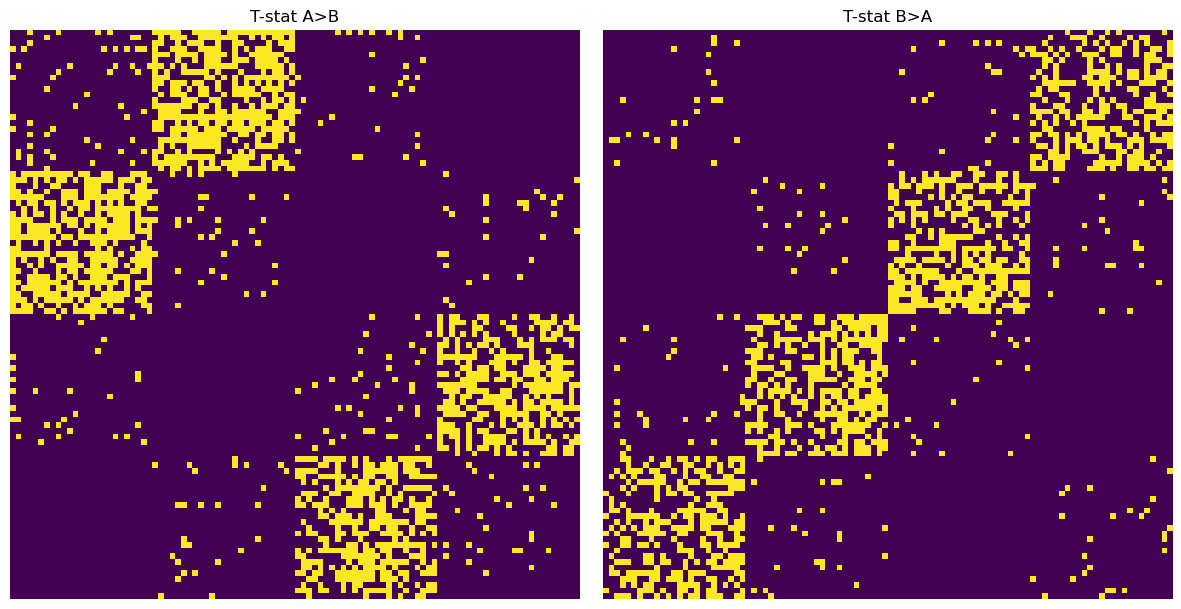

Wall time: 98 ms


In [37]:
%%time
t_stat = compute_t_stat_diff(taskA- taskB)
title1, title2 = "T-stat A>B", "T-stat B>A"
plot_2_matrix(t_stat['g2>g1']>1.65, t_stat['g1>g2']>1.65, title1, title2, cmap = 'viridis')


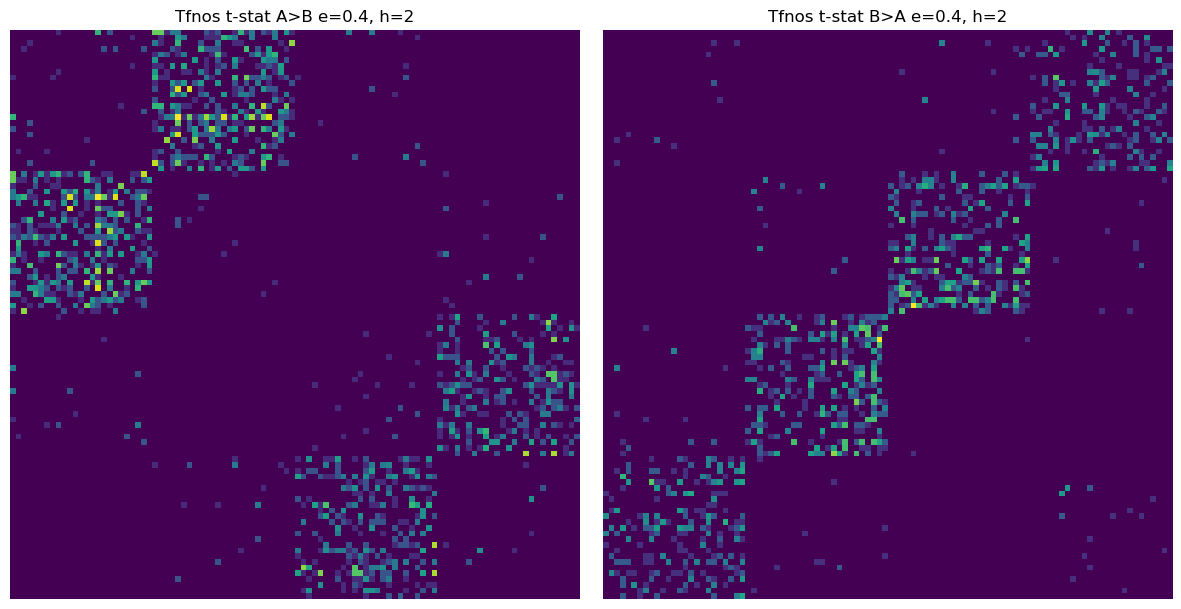

Wall time: 123 ms


In [40]:
%%time
e, h = 0.4, 2
t_stat_tfnos = compute_t_stat_tfnos_diffs(taskA- taskB, e=e, h=h, n=10, start_thres=1.7)
title1, title2 = f"Tfnos t-stat A>B e={e}, h={h}", f"Tfnos t-stat B>A e={e}, h={h}"
plot_2_matrix(t_stat_tfnos['g2>g1'], t_stat_tfnos['g1>g2'], title1, title2, cmap = 'viridis')

------

In [44]:
%%time
p_vals_orig = compute_p_val(taskB, 
                            taskA,
                            n_permutations=1000, 
                            paired=True, 
                            tf=False, 
                            use_mp=True)

Wall time: 9.3 s


In [45]:
p_vals_orig.keys()

dict_keys(['g2>g1', 'g1>g2'])

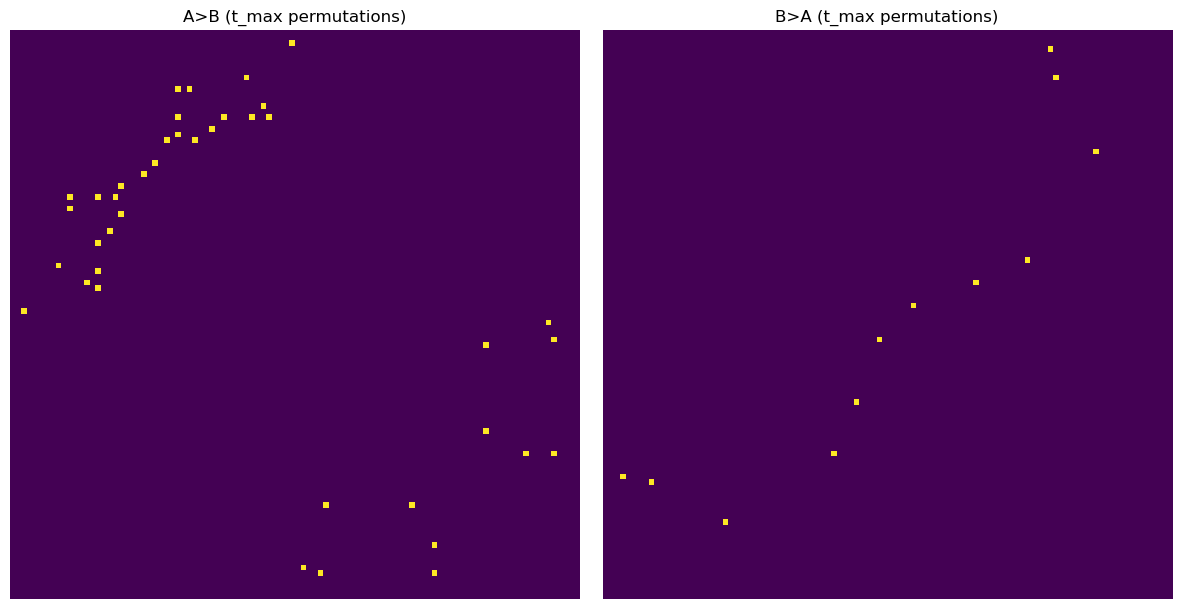

In [46]:
title1, title2 = "A>B (t_max permutations)", "B>A (t_max permutations)"
plot_2_matrix(p_vals_orig['g2>g1']<0.1, p_vals_orig['g1>g2']<0.1, title1, title2, cmap = 'viridis')


## Results
Depends on parameters, but quite stable, results very close and close to ground true and other methods, but to much faster, bigger h, lower e - more conservative

In [47]:
%%time
p_vals_tf = compute_p_val(taskB, 
                            taskA,
                            n_permutations=1000, 
                            paired=True, 
                            tf=True, 
                            use_mp=True,
                            e=[0.25, 0.25, 0.4, 0.4, 0.7, 0.7], 
                            h=[1, 3, 1, 3 , 1, 3],
                            n=15)

Wall time: 18.8 s


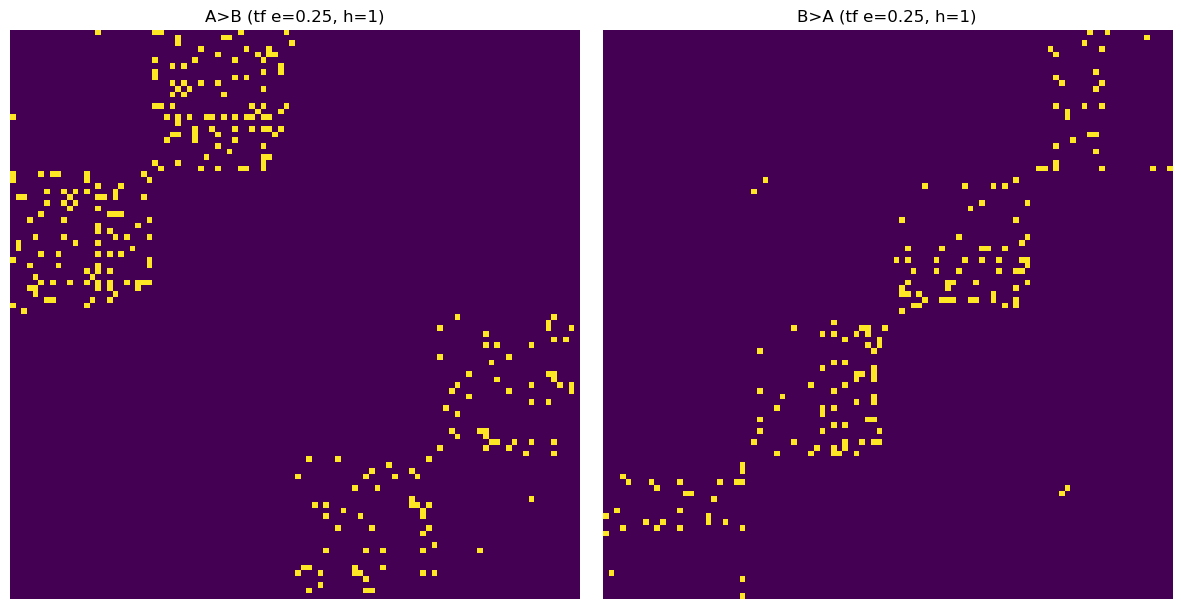

In [48]:
e, h = 0.25, 1
title1, title2 = f"A>B (tf e={e}, h={h})", f"B>A (tf e={e}, h={h})"
plot_2_matrix(p_vals_tf['g2>g1'][...,0]<0.05, p_vals_tf['g1>g2'][...,0]<0.05, title1, title2, cmap = 'viridis')


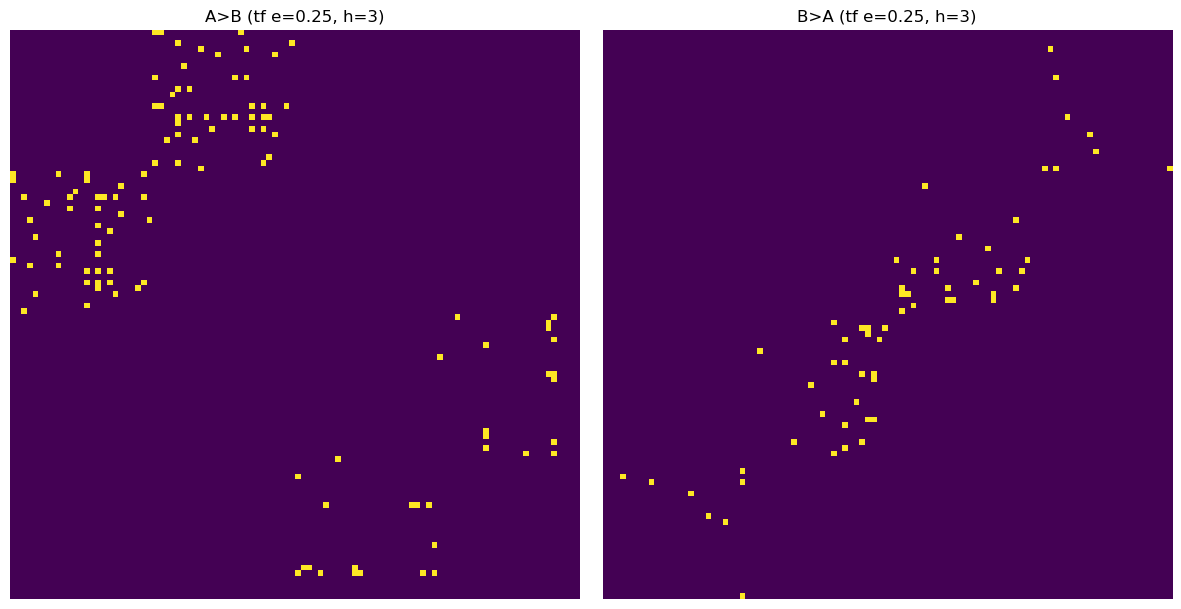

In [49]:
e, h = 0.25, 3
title1, title2 = f"A>B (tf e={e}, h={h})", f"B>A (tf e={e}, h={h})"
plot_2_matrix(p_vals_tf['g2>g1'][...,1]<0.05, p_vals_tf['g1>g2'][...,1]<0.05, title1, title2, cmap = 'viridis')

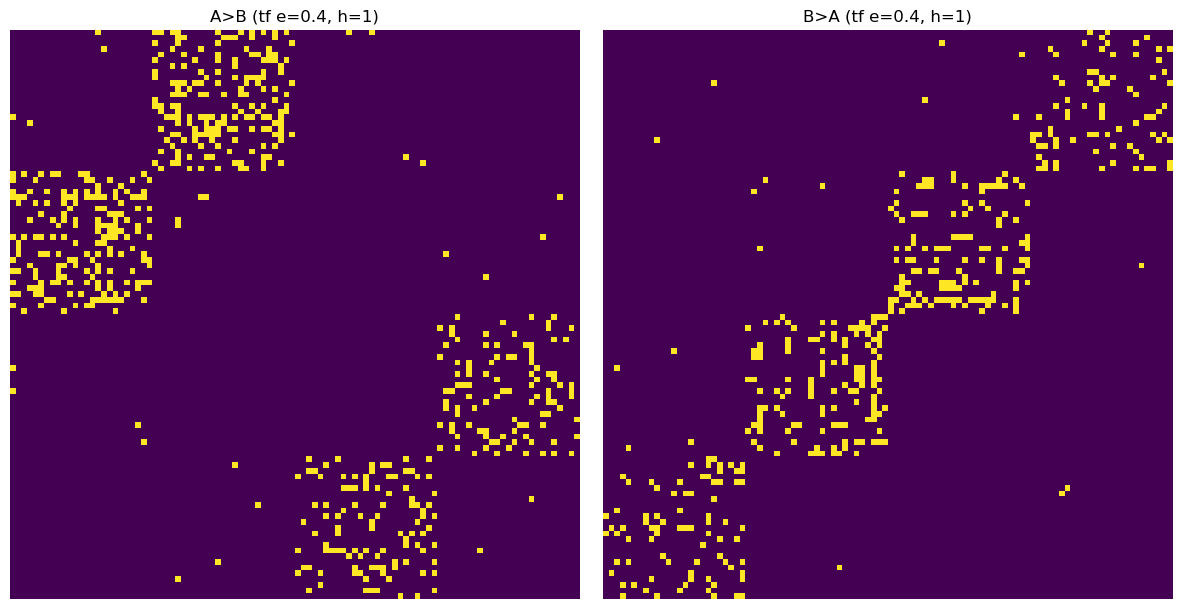

In [50]:
e, h = 0.4, 1
title1, title2 = f"A>B (tf e={e}, h={h})", f"B>A (tf e={e}, h={h})"
plot_2_matrix(p_vals_tf['g2>g1'][...,2]<0.05, p_vals_tf['g1>g2'][...,2]<0.05, title1, title2, cmap = 'viridis')

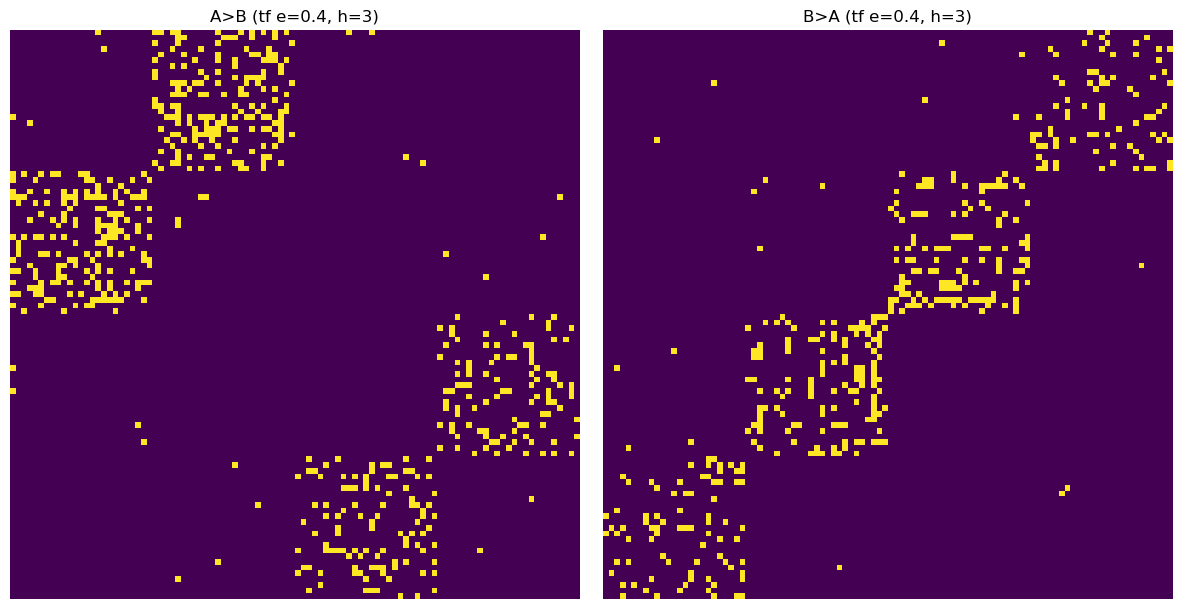

In [51]:
e, h = 0.4, 3
title1, title2 = f"A>B (tf e={e}, h={h})", f"B>A (tf e={e}, h={h})"
plot_2_matrix(p_vals_tf['g2>g1'][...,2]<0.05, p_vals_tf['g1>g2'][...,2]<0.05, title1, title2, cmap = 'viridis')

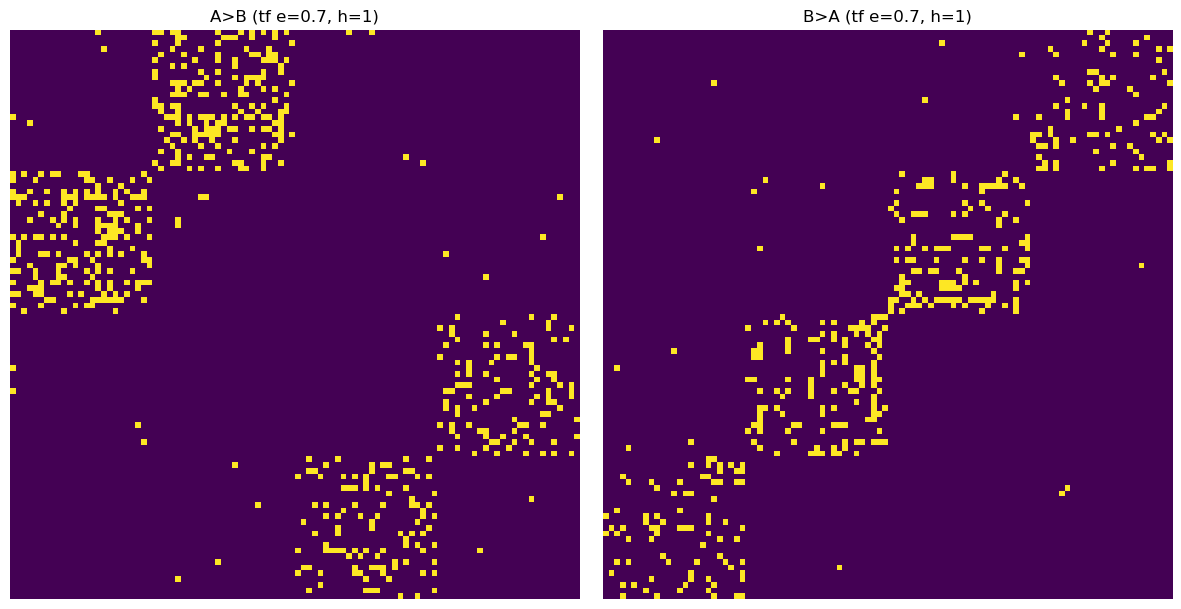

In [52]:
e, h = 0.7, 1
title1, title2 = f"A>B (tf e={e}, h={h})", f"B>A (tf e={e}, h={h})"
plot_2_matrix(p_vals_tf['g2>g1'][...,2]<0.05, p_vals_tf['g1>g2'][...,2]<0.05, title1, title2, cmap = 'viridis')

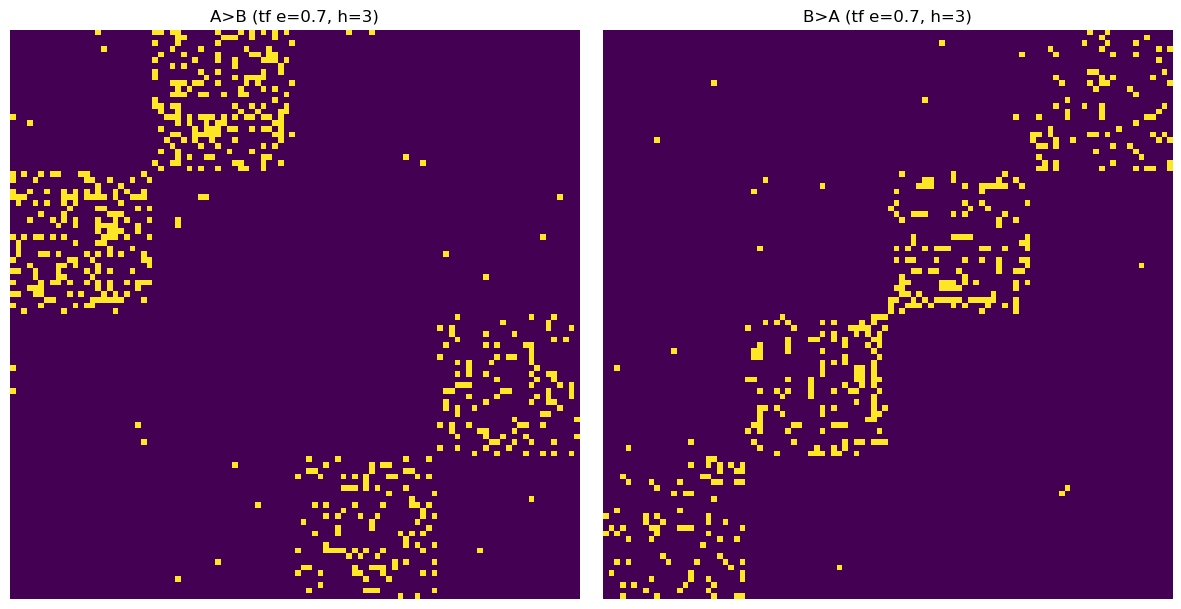

In [53]:
e, h = 0.7, 3
title1, title2 = f"A>B (tf e={e}, h={h})", f"B>A (tf e={e}, h={h})"
plot_2_matrix(p_vals_tf['g2>g1'][...,2]<0.05, p_vals_tf['g1>g2'][...,2]<0.05, title1, title2, cmap = 'viridis')

------

-----